In [134]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import integrate

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [135]:
def dist_spec(angle, prob_dist, grid_size, loc, offset):
    
    grid = [[0 for x in np.r_[0:grid_size]] for x in np.r_[0:grid_size]] 
    for i in np.r_[0:grid_size]:  #row
        for j in np.r_[0:grid_size]: #column
            if j == loc[1]:
                if i < loc[0]:
                    cell_angle = -pi/2
                else:
                    cell_angle = pi/2
            else:
                cell_angle = np.arctan(float((i-loc[0]))/float((j-loc[1])))
                if (i<loc[0]) and (j<loc[1]):
                    cell_angle = cell_angle - pi
                if (i> loc[0]) and (j< loc[1]):
                    cell_angle = cell_angle
                #if (i)
#             print 'i: %d, j: %d angle: %f' % (i, j, cell_angle)
            cell_angle = cell_angle
            # finding the closest point in angle
            dif = []
            for k in angle:
                value = abs(k-cell_angle)
                dif.append(value)
            index = np.argmin(dif)   
            #grid[i][j] = cell_angle
            grid[i][j] = prob_dist[index]
            if i < loc[0]:
                grid[i][j] = 0
            
    # Ploting angle and prob_dist
    t = np.r_[0:grid_size]
    plt.figure()
    plt.plot(angle, prob_dist)
    plt.title('Probabillity distribution')
            
    # ploting the grid
    fig = plt.figure(figsize=(10, 10))
    plt.xticks(np.r_[0:grid_size])
    plt.yticks(np.r_[0:grid_size])
    axes = plt.gca()
    axes.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.5')
    axes.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.5')
#     axes.set_xlim(0, grid_size)
#     axes.set_ylim(0, grid_size)
    plt.imshow(grid, origin='lower', vmax = 1, interpolation='nearest')
    plt.colorbar()
    return grid
    
    
    
    

In [223]:
def rotate_spec(angle, prob_dist, grid_size, loc, offset):
    grid = [[0 for x in np.r_[0:grid_size]] for x in np.r_[0:grid_size]] 
    for i in np.r_[0:grid_size]:  #row
        for j in np.r_[0:grid_size]: #column
            if j == loc[1]:
                if i < loc[0]:
                    cell_angle = -pi/2
                else:
                    cell_angle = pi/2
            else:
                cell_angle = np.arctan(float((i-loc[0]))/float((j-loc[1])))
                if (i<loc[0]) and (j<loc[1]):
                    cell_angle = cell_angle - pi
                if (i> loc[0]) and (j< loc[1]):
                    cell_angle = cell_angle
               
            cell_angle = cell_angle + offset
    
            if cell_angle > np.pi:
                cell_angle = cell_angle - 2*np.pi
            elif cell_angle < -np.pi:
                cell_angle = cell_angle + 2*np.pi
    
            # finding the closest point in angle
            index = np.argmin(abs(angle-cell_angle))
           
            if min(angle) <= cell_angle <= max(angle):
                grid[i][j] = prob_dist[index]
            else:
                grid[i][j] = 0
            
                
            
#     # Ploting angle and prob_dist
#     t = np.r_[0:grid_size]
#     plt.figure()
#     plt.plot(angle, prob_dist)
#     plt.title('Probabillity distribution')
            
#     # ploting the grid
#     fig = plt.figure(figsize=(10, 10))
#     plt.xticks(np.r_[0:grid_size])
#     plt.yticks(np.r_[0:grid_size])
#     axes = plt.gca()
#     axes.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.5')
#     axes.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.5')
#     plt.imshow(grid, origin='lower', vmax = 1, interpolation='nearest')
#     plt.colorbar()
    return grid
    
    
    
    

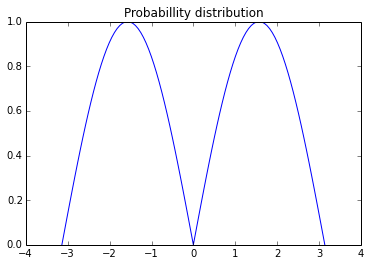

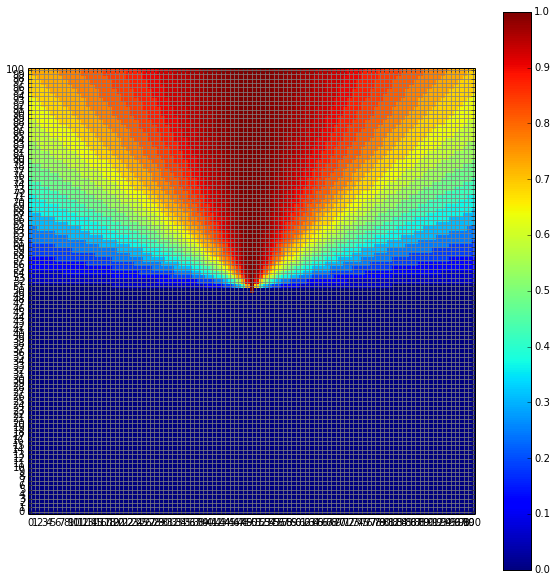

In [213]:
size = 101
angle = np.linspace(-pi, pi, size)
prob_dist = abs(np.sin(angle))
grid = dist_spec(angle, prob_dist, size, [int(size/2), int(size/2)],-pi/2)


In [231]:
def prob_matrix_calculation(angle, prob, grid_size, loc, offset):
    grid1 = rotate_spec(angle[0], prob[0], grid_size, loc[0], offset[0])
    grid2 = rotate_spec(angle[1], prob[1], grid_size, loc[1], offset[1])
    grid3 = rotate_spec(angle[2], prob[2], grid_size, loc[2], offset[2])
    grid = np.multiply(grid3, np.multiply(grid1, grid2))
    grid = grid / np.sum(grid)
    
#     # Ploting angle and prob_dist
#     t = np.r_[0:grid_size]
#     plt.figure()
#     plt.plot(angle, prob_dist)
#     plt.title('Probabillity distribution')
            
    # ploting the grid
    fig = plt.figure(figsize=(10, 10))
    plt.xticks(np.r_[0:grid_size])
    plt.yticks(np.r_[0:grid_size])
    axes = plt.gca()
    axes.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.5')
    axes.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.5')
    plt.imshow(grid, origin='lower', interpolation='nearest')
    plt.colorbar()
    
    return grid
    

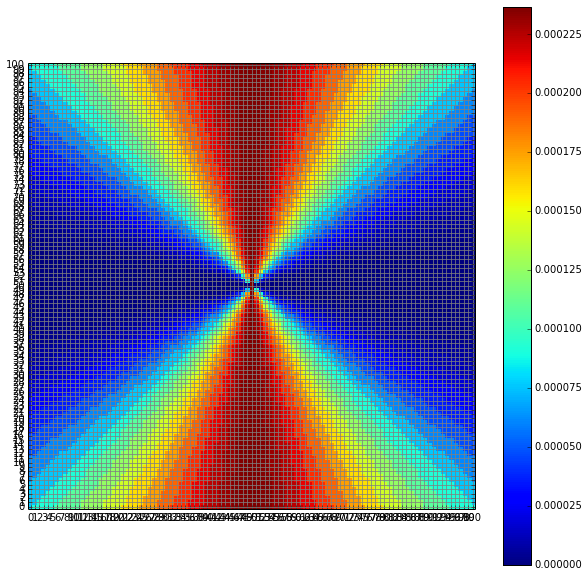

In [232]:
size = 101
angle = np.linspace(-pi, pi, size)
prob_dist = abs(np.sin(angle))
grid = prob_matrix_calculation([angle]*3, [prob_dist]*3, size, [[int(size/2), int(size/2)]]*3, [0]*3)
# rotate = rotate_spec(angle, prob_dist, size, [int(size/2), int(size/2)], -pi/4)

In [ ]:
class MatrixProbability:
    
    def __init__(self, locs, orientations, grid_size):
        """
        locs: list of locations
        orientations: list of orientations
        """
        self.locs = locs
        self.orientations = orientations
        self.grid_size = grid_size
    
    
    def update_probability(self, ith, angle, prob):
        """
        update internal probability distribution for ith sdr given angle/prob
        """
        grid = rotate_spec(angle, prob, self.grid_size, loc[ith], offset[ith])
        if not self.grid:
            self.grid = grid
        else:
            self.grid = np.multiply(self.grid, grid)
    
    
    def get_probabililty(self):
        return self.grid
    
    
    def rotate_spec(angle, prob_dist, grid_size, loc, offset):
        grid = [[0 for x in np.r_[0:grid_size]] for x in np.r_[0:grid_size]] 
        for i in np.r_[0:grid_size]:  #row
            for j in np.r_[0:grid_size]: #column
                if j == loc[1]:
                    if i < loc[0]:
                        cell_angle = -pi/2
                    else:
                        cell_angle = pi/2
                else:
                    cell_angle = np.arctan(float((i-loc[0]))/float((j-loc[1])))
                    if (i<loc[0]) and (j<loc[1]):
                        cell_angle = cell_angle - pi
                    if (i> loc[0]) and (j< loc[1]):
                        cell_angle = cell_angle

                cell_angle = cell_angle + offset

                if cell_angle > np.pi:
                    cell_angle = cell_angle - 2*np.pi
                elif cell_angle < -np.pi:
                    cell_angle = cell_angle + 2*np.pi

                # finding the closest point in angle
                index = np.argmin(abs(angle-cell_angle))

                if min(angle) <= cell_angle <= max(angle):
                    grid[i][j] = prob_dist[index]
                else:
                    grid[i][j] = 0

        return grid
    